In [3]:
import sys
import os
sys.path.append('/global/u2/c/caditi97/exatrkx-ctd2020')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from utils_robust import *

In [4]:
# for no ptcut = "/global/cfs/projectdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
# xiangyang's model = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
# misaligned data = "/global/cfs/projectdirs/m3443/data/trackml-kaggle/misaligned"
# noise path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
artifact_storage_path = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl') 
event_path = "/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/robust_test/output/misaligned/"
mcm = ["20","100","400","600","800","1000"]
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

In [7]:
f_eff = []
f_purity = []
e_eff = []
e_purity = []
for mc in mcm:
    print("Volume 8 layer 6 Misalignment = " +mc+ " micrometers")
    event_name = "event000009900_8_" +mc+ ".pickle"
    hits, truth, emb_model, filter_model = get_data(best_emb_path, best_filter_path, event_name, event_path)
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors, only_adjacent=True)
    idx_pairs, filter_pairs = use_filter(hits, neighbors) 
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, idx_pairs, filter_pairs)
    f_eff.append(filter_efficiency)
    f_purity.append(filter_purity)
    e_eff.append(emb_efficiency)
    e_purity.append(emb_purity)

Volume 8 layer 6 Misalignment = 20 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:20<00:00, 322.73it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279433it [00:08, 906106.00it/s]


Volume 8 layer 6 Misalignment = 100 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:21<00:00, 321.35it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279445it [00:08, 908949.17it/s]


Volume 8 layer 6 Misalignment = 400 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:21<00:00, 322.52it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279331it [00:07, 927567.55it/s]


Volume 8 layer 6 Misalignment = 600 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:20<00:00, 322.78it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279405it [00:07, 930717.80it/s]


Volume 8 layer 6 Misalignment = 800 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:20<00:00, 323.27it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279559it [00:07, 927590.49it/s]


Volume 8 layer 6 Misalignment = 1000 micrometers
noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:20<00:00, 323.80it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279439it [00:07, 932030.89it/s]


In [65]:

def stat_mean(d):
    n = []
    for i in d:
        n.append(statistics.mean(i))
    return n

def stat_round(d):
    n = []
    for i in d:
        n.append(round(i,3))
    return n

f_e = stat_round(f_eff)
f_p = stat_round(f_purity)
e_e = stat_round(stat_mean(e_eff))
e_p = stat_round(stat_mean(e_purity))

In [66]:
e_e

[0.989, 0.989, 0.989, 0.989, 0.989, 0.989]

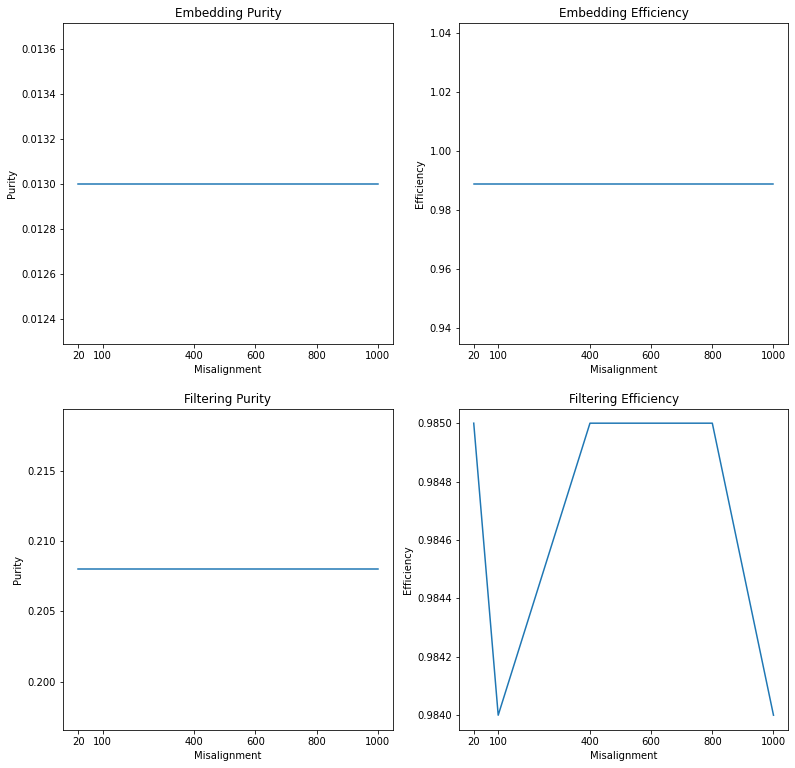

In [68]:
f, a = plt.subplots(2,2, figsize=(13,13))
x = [int(m) for m in mcm]
a[0][0].plot(x,e_p)
a[0][0].set_title("Embedding Purity")
a[0][0].set_xlabel("Misalignment")
a[0][0].set_xticks([20,100,400,600,800,1000])
a[0][0].set_ylabel("Purity")

a[0][1].plot(x,e_e)
a[0][1].set_title("Embedding Efficiency")
a[0][1].set_xticks([20,100,400,600,800,1000])
a[0][1].set_xlabel("Misalignment")
a[0][1].set_ylabel("Efficiency")

a[1][0].plot(x,f_p)
a[1][0].set_title("Filtering Purity")
a[1][0].set_xticks([20,100,400,600,800,1000])
a[1][0].set_xlabel("Misalignment")
a[1][0].set_ylabel("Purity")

a[1][1].plot(x,f_e)
a[1][1].set_title("Filtering Efficiency")
a[1][1].set_xticks([20,100,400,600,800,1000])
a[1][1].set_xlabel("Misalignment")
a[1][1].set_ylabel("Efficiency")

plt.show()

In [70]:
ev_n = "event000009900.pickle"
hits_o, truth_o, emb_model, filter_model = get_data(best_emb_path, best_filter_path, ev_n, event_path)
nbrs = get_emb_neighbors(hits_o[feature_names].values, emb_model, 0.4)
emb_p_o, emb_e_o = get_emb_eff_purity(hits_o, truth_o, nbrs, only_adjacent=True)
idx_pairs_o, filter_pairs_o = use_filter(hits_o, nbrs) 
f_p_o, f_e_o = get_filter_eff_purity(hits_o, truth_o, idx_pairs_o, filter_pairs_o)

noise: 0 number of hits: 45482


100%|██████████| 45482/45482 [02:20<00:00, 322.94it/s]


    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


7279553it [00:07, 939360.19it/s]


In [85]:
emb_eff_o = statistics.mean(emb_e_o)
emb_eff_o

0.988658374477782

In [86]:
e0 = np.zeros(len(e_e)) + emb_eff_o
obs_eff_loss = e0 - stat_mean(e_eff)

In [87]:
obs_eff_loss

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.58247879e-05])